# Описание проекта

**Заказчик:** Оператор связи "Ниединогоразрыва.ком". Предоставляет два основных типа услуг: стационарная телефонная связь, интернет. А также ряд сопутствующих услуг.

**Цель проекта:** Создать модель, которая будет определять клиентов, которые собираются отказаться от услуг компании. Пользователям, которые собираются уйти, будут предлагаться специальные условия для того, чтобы удержать клиента.

**Требования:** Метрика *AUC_ROC* выше 0.85

# План работы

1. Подготовка информации
    - Объединить данные, избавиться от аномалий и привести в общему виду
2. EDA
    - Посмотреть на распределение целевого признака
    - Изучить категориальные и количественные признаки
3. Обучение модели
    - Подготовить данные для обучения (закодировать и разбить на выборки)
    - Выбрать модель для обучения
    - Оптимизировать лучшую модель и выполнить требования заказчика относительно модели

# Знакомство с данными

## Импорт библиотек

In [1]:
# библиотеки для работы с данными
import pandas as pd
import numpy as np
import re

# для визуализации данных
import seaborn as sns 
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMRegressor

# Для обучения модели
import catboost
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (auc, roc_curve, roc_auc_score,
                            accuracy_score, precision_score,
                            recall_score, confusion_matrix,
                            ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

# Отключим некритические предупреждения в коде
import warnings
warnings.filterwarnings('ignore')

# Константа
RANDOM_STATE = 250923

# Смена темы графиков 
sns.set_theme(style="darkgrid")

## Импорт данных

In [2]:
local_path = 'C:/Users/fryle/Downloads/'
server_path = '/datasets/'

try:
    internet = pd.read_csv(local_path + 'internet_new.csv')
    personal = pd.read_csv(local_path + 'personal_new.csv')
    phone = pd.read_csv(local_path + 'phone_new.csv')
    contract = pd.read_csv(local_path + 'contract_new.csv')
except:
    internet = pd.read_csv(server_path + 'internet_new.csv')
    personal = pd.read_csv(server_path + 'personal_new.csv')
    phone = pd.read_csv(server_path + 'phone_new.csv')
    contract = pd.read_csv(server_path + 'contract_new.csv')

## Изучения сырых данных

In [3]:
def whole_info(df):
    display(df.head(10))
    print('\n\n')
    display(df.info())
    print('\n\n')
    display(df.describe())

### internet

In [4]:
whole_info(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


### personal

In [5]:
whole_info(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


### phone

In [6]:
whole_info(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


### contract

In [7]:
whole_info(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


### Вывод

В некоторых таблицах кол-во строк меньше, чем в других. Значит у них не подключены все услуги.

## Предобработка

In [8]:
# функция для перевода столбца в змеиный регистр
def to_snake_case(columns_names):
    snake_names = []
    for name in columns_names:
        name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
        name = re.sub('__([A-Z])', r'_\1', name)
        name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)
        snake_names.append(name.lower())
    return snake_names

### Объединение данных

In [9]:
df = personal.merge(internet, how='left', on='customerID')
df = df.merge(phone, how='left', on='customerID')
df = df.merge(contract, how='left', on='customerID')

Приведем наименования столбцов к змеиному регистру

In [10]:
df.columns = to_snake_case(df.columns)

In [11]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   int64  
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   internet_service   5517 non-null   object 
 6   online_security    5517 non-null   object 
 7   online_backup      5517 non-null   object 
 8   device_protection  5517 non-null   object 
 9   tech_support       5517 non-null   object 
 10  streaming_tv       5517 non-null   object 
 11  streaming_movies   5517 non-null   object 
 12  multiple_lines     6361 non-null   object 
 13  begin_date         7043 non-null   object 
 14  end_date           7043 non-null   object 
 15  type               7043 non-null   object 
 16  paperless_billing  7043 

Появились пропуски в данных, надо их обработать.

In [13]:
df.duplicated().sum()

0

Явных дубликатов не наблюдается.

### Пропуски

Пропуски появились на местах, где клиент не пользуется пакетом в целом, добавим дополнительную категорию.

In [14]:
df = df.fillna('Don\'t use whole pack' )

In [15]:
df.isna().sum()

customer_id          0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

### Дата

In [16]:
df[['begin_date', 'end_date']].head(10)

,begin_date,end_date
0,2020-01-01,No
1,2017-04-01,No
2,2019-10-01,No
3,2016-05-01,No
4,2019-09-01,No
5,2019-03-01,No
6,2018-04-01,No
7,2019-04-01,No
8,2017-07-01,No
9,2014-12-01,2017-05-01


In [17]:
df[df['end_date'] != 'No']['end_date'].shape

(1101,)

У нас есть 1101 клиентов, которые ушли от компании.

In [18]:
df['dubl_end_date'] = df['end_date']

In [19]:
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')
df['end_date'] = pd.to_datetime(df[df['end_date'] != 'No']['end_date'], format='%Y-%m-%d')

Пропуски заменим здесь на актуальную дату.

In [20]:
df['end_date'] = df['end_date'].fillna(pd.to_datetime('2020-02-01', format='%Y-%m-%d'))

In [21]:
df[['begin_date', 'end_date']].head(10)

,begin_date,end_date
0,2020-01-01,2020-02-01
1,2017-04-01,2020-02-01
2,2019-10-01,2020-02-01
3,2016-05-01,2020-02-01
4,2019-09-01,2020-02-01
5,2019-03-01,2020-02-01
6,2018-04-01,2020-02-01
7,2019-04-01,2020-02-01
8,2017-07-01,2020-02-01
9,2014-12-01,2017-05-01


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   senior_citizen     7043 non-null   int64         
 3   partner            7043 non-null   object        
 4   dependents         7043 non-null   object        
 5   internet_service   7043 non-null   object        
 6   online_security    7043 non-null   object        
 7   online_backup      7043 non-null   object        
 8   device_protection  7043 non-null   object        
 9   tech_support       7043 non-null   object        
 10  streaming_tv       7043 non-null   object        
 11  streaming_movies   7043 non-null   object        
 12  multiple_lines     7043 non-null   object        
 13  begin_date         7043 non-null   datetime64[ns]
 14  end_date

### total_charges

По какой-то причине этот столбец не `float`, а `object`.

In [23]:
df[df['total_charges'] == ' ']

,customer_id,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,...,streaming_movies,multiple_lines,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,dubl_end_date
488,4472-LVYGI,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,...,No,Don't use whole pack,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,...,Don't use whole pack,No,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,...,Yes,No,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,...,Don't use whole pack,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,...,No,Don't use whole pack,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,...,Don't use whole pack,No,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,...,Don't use whole pack,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,...,Don't use whole pack,No,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,...,Don't use whole pack,No,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,...,No,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,No


Похоже, что пропуски у новых клиентов, вероятно они еще не успели занести даже первый платеж. Думаю справедливо будет поставить ежемесячный платеж вместо пустот. После переведем столбец в нужный нам тип.

In [24]:
df.loc[df['total_charges'] == ' ', 'total_charges'] = df.loc[df['total_charges'] == ' ', 'monthly_charges']
df['total_charges'] = df['total_charges'].astype('float')

In [25]:
# Проверим столбец
display(df.info())
display(df[df['begin_date'] == '2020-02-01'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   senior_citizen     7043 non-null   int64         
 3   partner            7043 non-null   object        
 4   dependents         7043 non-null   object        
 5   internet_service   7043 non-null   object        
 6   online_security    7043 non-null   object        
 7   online_backup      7043 non-null   object        
 8   device_protection  7043 non-null   object        
 9   tech_support       7043 non-null   object        
 10  streaming_tv       7043 non-null   object        
 11  streaming_movies   7043 non-null   object        
 12  multiple_lines     7043 non-null   object        
 13  begin_date         7043 non-null   datetime64[ns]
 14  end_date

None

,customer_id,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,...,streaming_movies,multiple_lines,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,dubl_end_date
488,4472-LVYGI,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,...,No,Don't use whole pack,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,No
753,3115-CZMZD,Male,0,No,Yes,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,...,Don't use whole pack,No,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,No
936,5709-LVOEQ,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,...,Yes,No,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,No
1082,4367-NUYAO,Male,0,Yes,Yes,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,...,Don't use whole pack,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,25.75,No
1340,1371-DWPAZ,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,...,No,Don't use whole pack,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,56.05,No
3331,7644-OMVMY,Male,0,Yes,Yes,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,...,Don't use whole pack,No,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,19.85,No
3826,3213-VVOLG,Male,0,Yes,Yes,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,...,Don't use whole pack,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,25.35,No
4380,2520-SGTTA,Female,0,Yes,Yes,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,...,Don't use whole pack,No,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,20.00,No
5218,2923-ARZLG,Male,0,Yes,Yes,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,Don't use whole pack,...,Don't use whole pack,No,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,19.70,No
6670,4075-WKNIU,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,...,No,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,73.35,No


## Дополнение данных

### Срок жизни клиента

In [26]:
# Добавим столбец с разницей двух столбцов дат
df['lifetime'] = (df['end_date'] - df['begin_date']).dt.days

In [27]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,...,multiple_lines,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,dubl_end_date,lifetime
0,7590-VHVEG,Female,0,Yes,No,DSL,No,Yes,No,No,...,Don't use whole pack,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,No,31
1,5575-GNVDE,Male,0,No,No,DSL,Yes,No,Yes,No,...,No,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,No,1036
2,3668-QPYBK,Male,0,No,No,DSL,Yes,Yes,No,No,...,No,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,No,123
3,7795-CFOCW,Male,0,No,No,DSL,Yes,No,Yes,Yes,...,Don't use whole pack,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,No,1371
4,9237-HQITU,Female,0,No,No,Fiber optic,No,No,No,No,...,No,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,No,153


### Целевой признак

Им будет значение ушел ли клиент или остался.

In [28]:
# Клиенты, которые остались будут 1
df['left'] = np.nan
df.loc[df['dubl_end_date'] == 'No', 'left'] = 0
df['left'] = df['left'].fillna(1).astype('int')

In [29]:
df['left'].value_counts()

0    5942
1    1101
Name: left, dtype: int64

In [30]:
df = df.drop(['dubl_end_date'], axis=1)

In [31]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,...,multiple_lines,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,lifetime,left
0,7590-VHVEG,Female,0,Yes,No,DSL,No,Yes,No,No,...,Don't use whole pack,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,31,0
1,5575-GNVDE,Male,0,No,No,DSL,Yes,No,Yes,No,...,No,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1036,0
2,3668-QPYBK,Male,0,No,No,DSL,Yes,Yes,No,No,...,No,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,123,0
3,7795-CFOCW,Male,0,No,No,DSL,Yes,No,Yes,Yes,...,Don't use whole pack,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,1371,0
4,9237-HQITU,Female,0,No,No,Fiber optic,No,No,No,No,...,No,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,153,0


### Избыточные столбцы

Есть несколько столбцов, которые только навредят модели: `customer_id`, `begin_date`, `end_date`. Избавимся от них.

In [32]:
df = df.drop(columns=['customer_id', 'begin_date', 'end_date'], axis=1)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   int64  
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   internet_service   7043 non-null   object 
 5   online_security    7043 non-null   object 
 6   online_backup      7043 non-null   object 
 7   device_protection  7043 non-null   object 
 8   tech_support       7043 non-null   object 
 9   streaming_tv       7043 non-null   object 
 10  streaming_movies   7043 non-null   object 
 11  multiple_lines     7043 non-null   object 
 12  type               7043 non-null   object 
 13  paperless_billing  7043 non-null   object 
 14  payment_method     7043 non-null   object 
 15  monthly_charges    7043 non-null   float64
 16  total_charges      7043 

## EDA

### Целевой признак

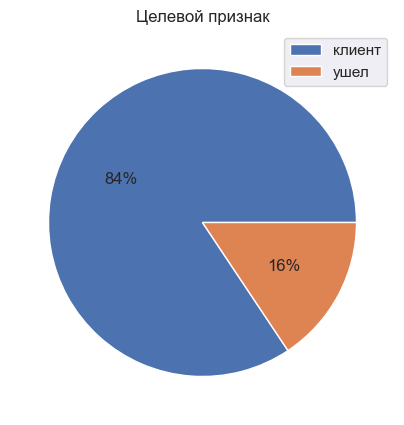

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.pie(df['left'].value_counts(), autopct='%.0f%%')
plt.legend(['клиент', 'ушел'])
plt.title('Целевой признак')
plt.show()

Есть дисбаланс данных.

In [35]:
def hist(x, ax, title):
    sns.histplot(df, x=x, hue='left', stat='density', ax=ax, common_norm=False, kde=True).set_title(title)

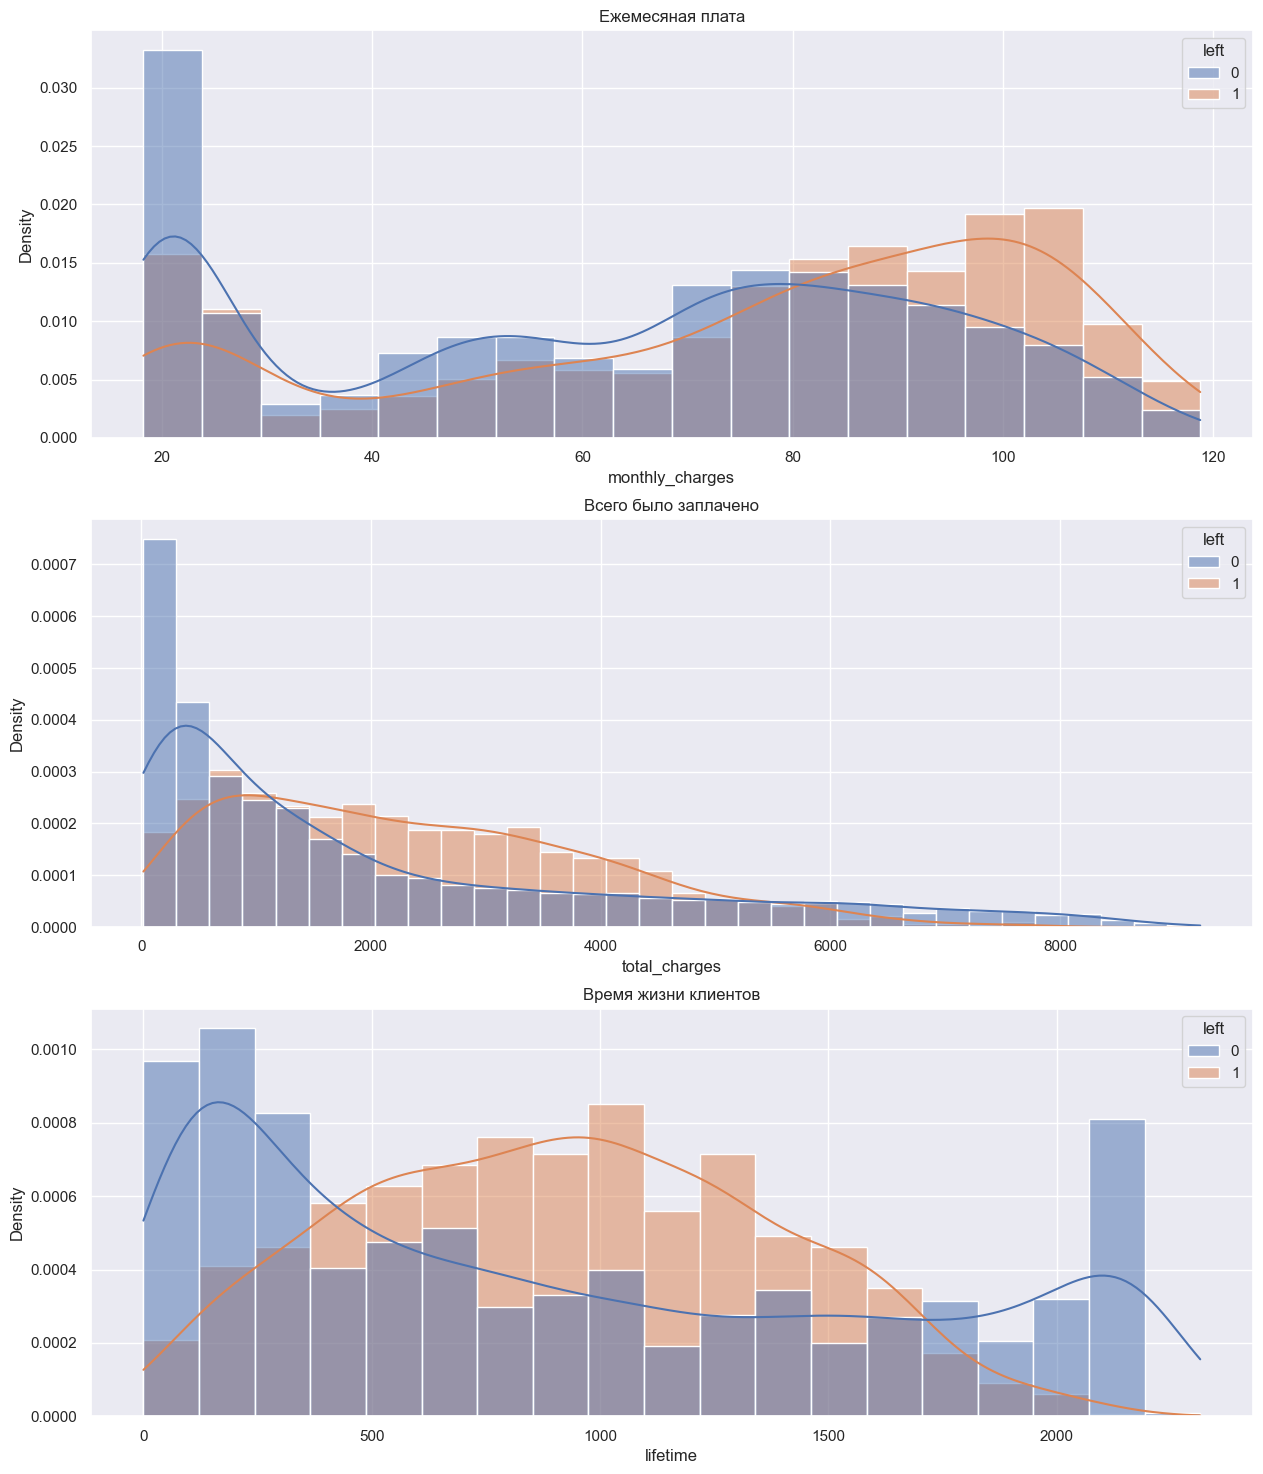

In [36]:
fig, ax = plt.subplots(3, 1, figsize=(15, 18))
columns = ['monthly_charges', 'total_charges', 'lifetime']
names = ['Ежемесяная плата', 'Всего было заплачено', 'Время жизни клиентов']

for i in range(3):
    hist(columns[i], ax[i], names[i])

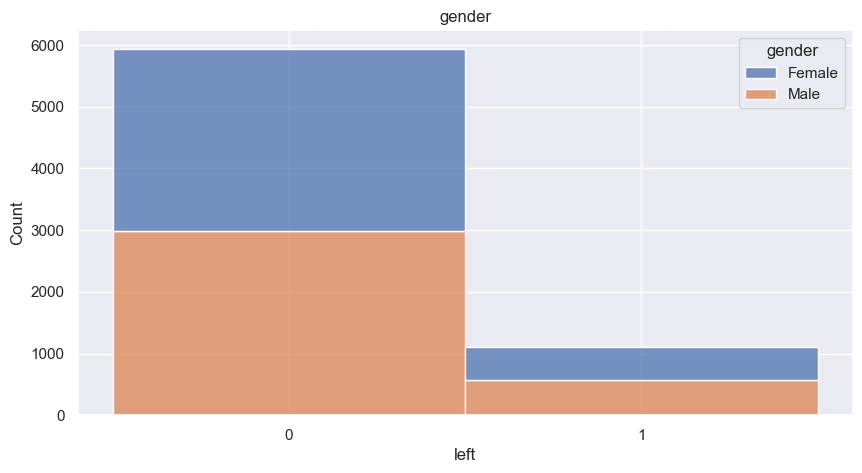

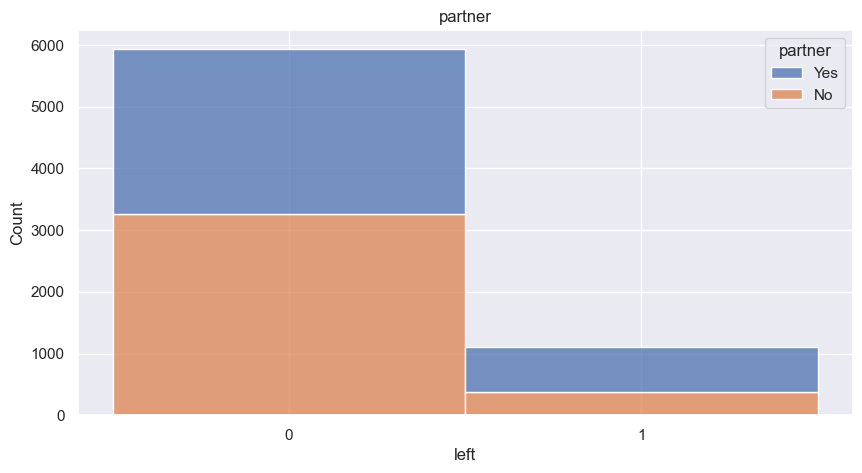

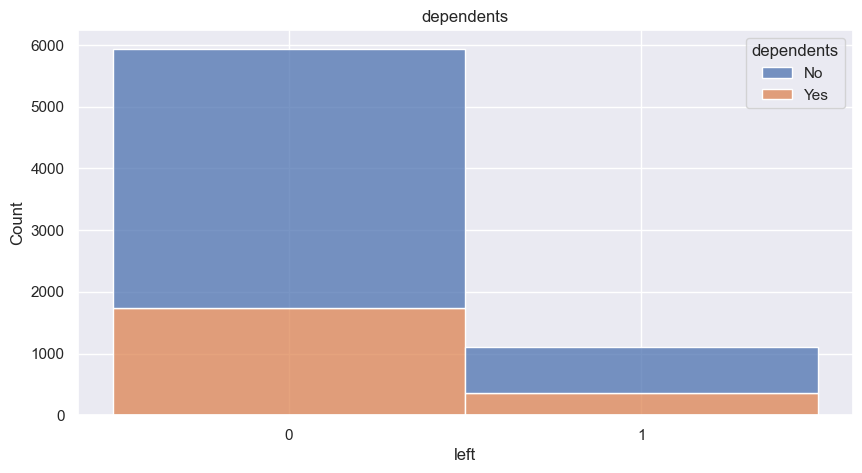

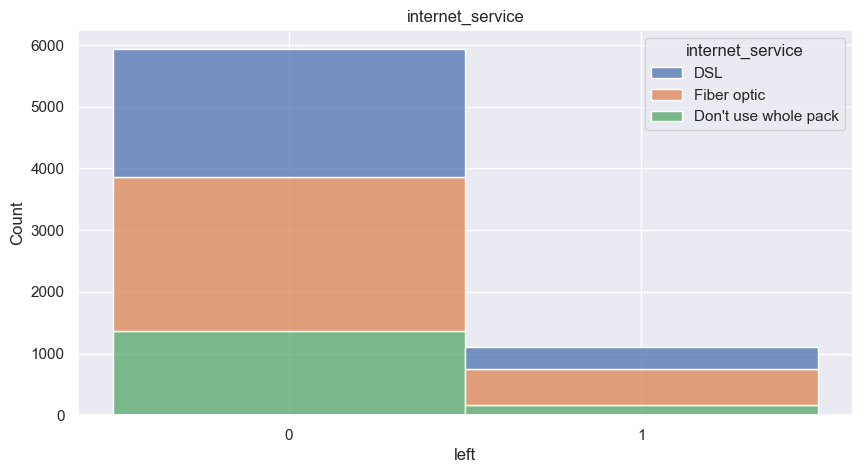

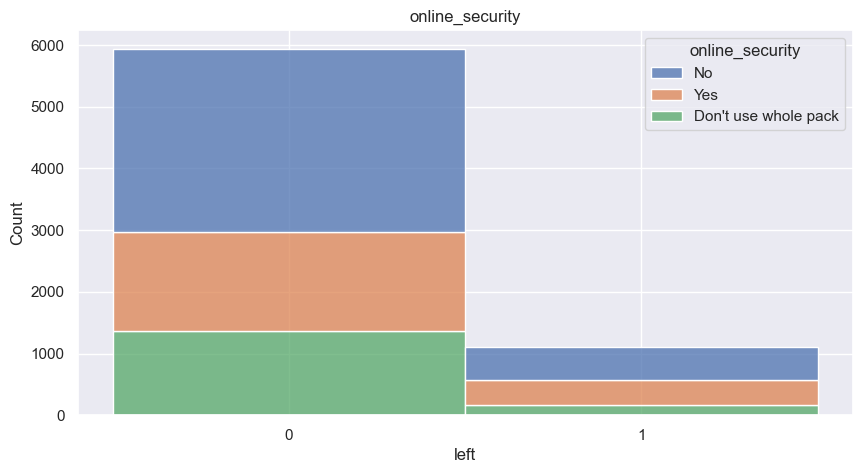

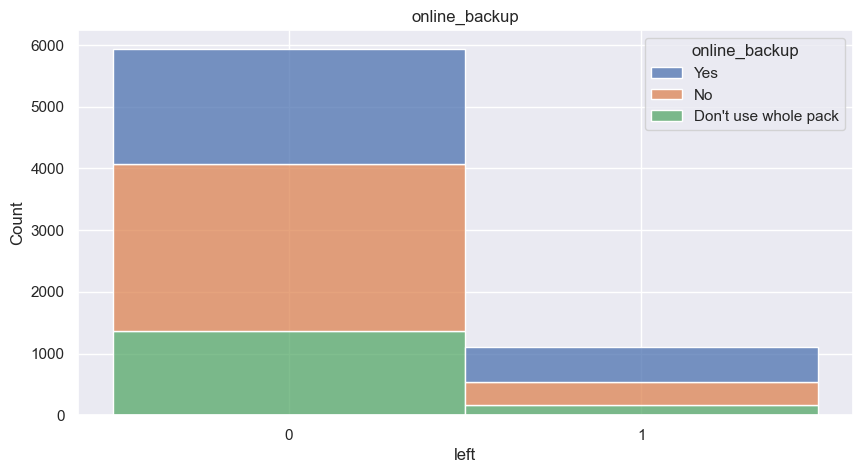

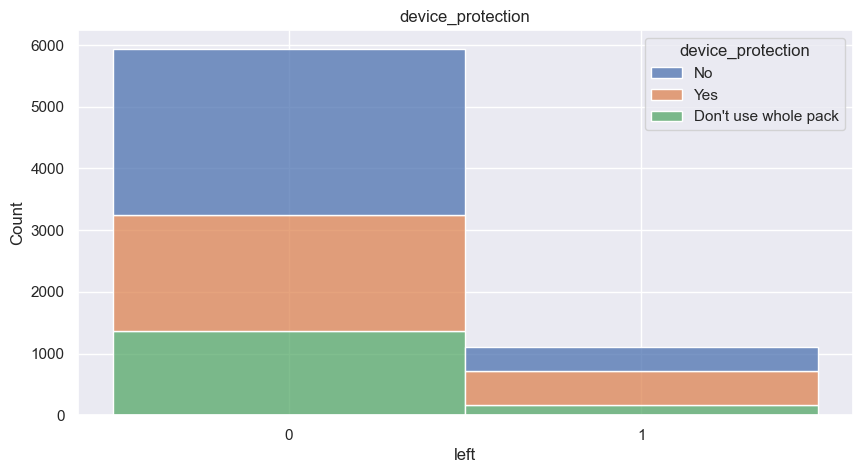

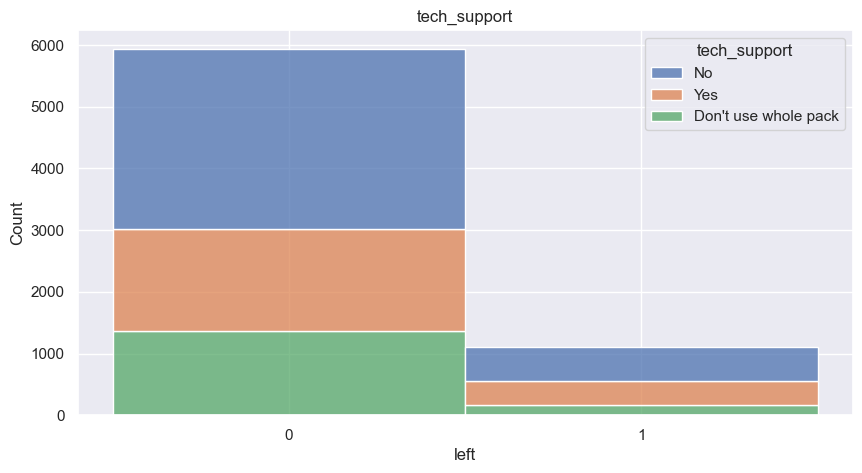

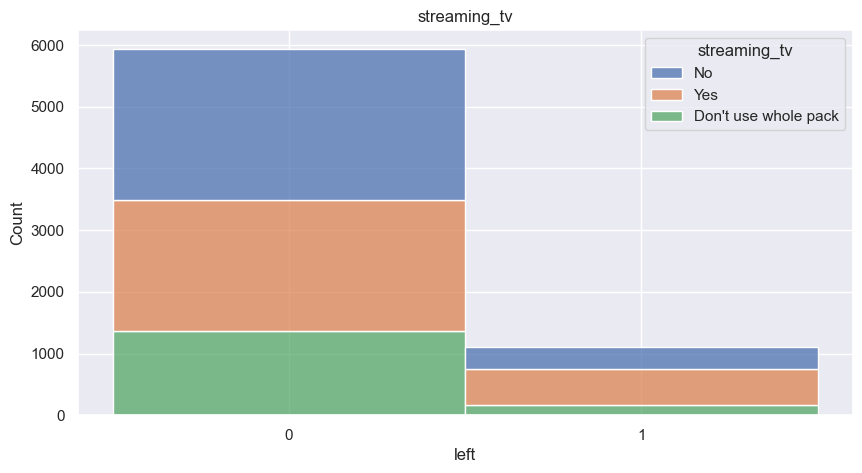

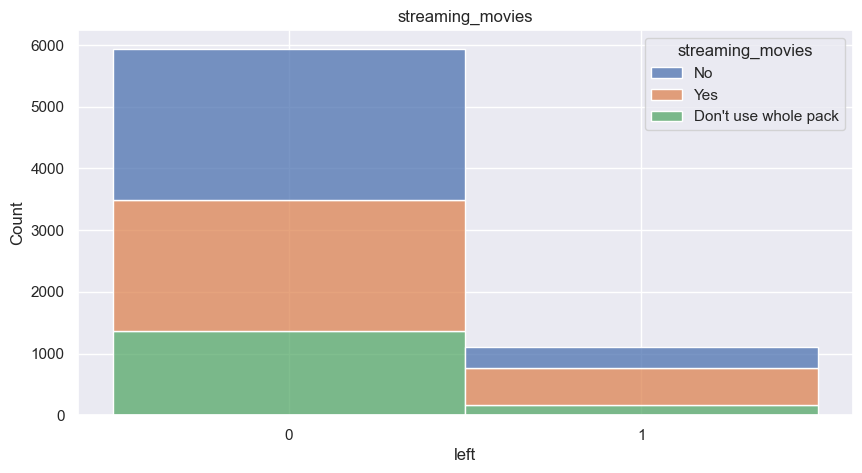

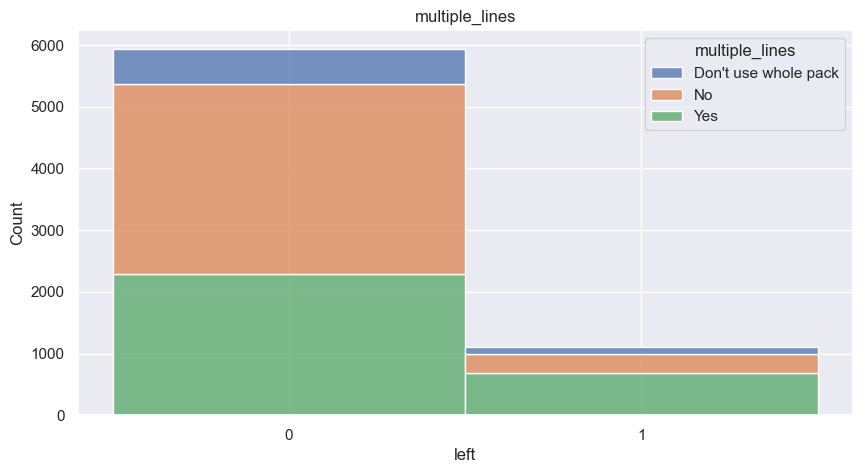

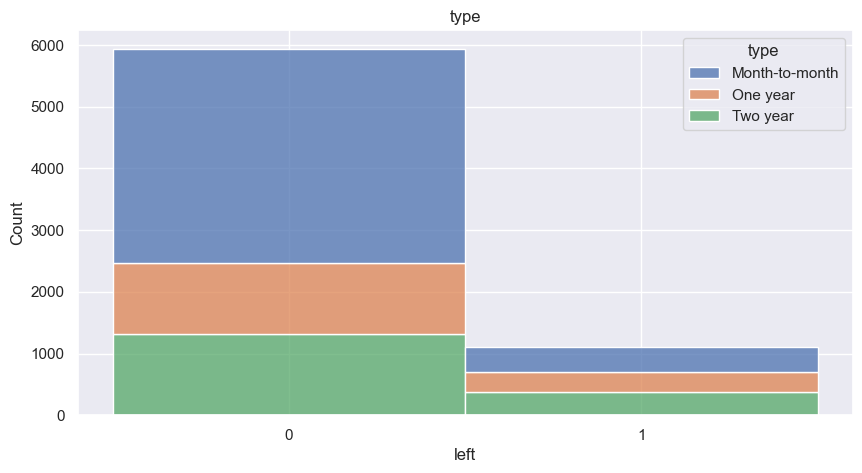

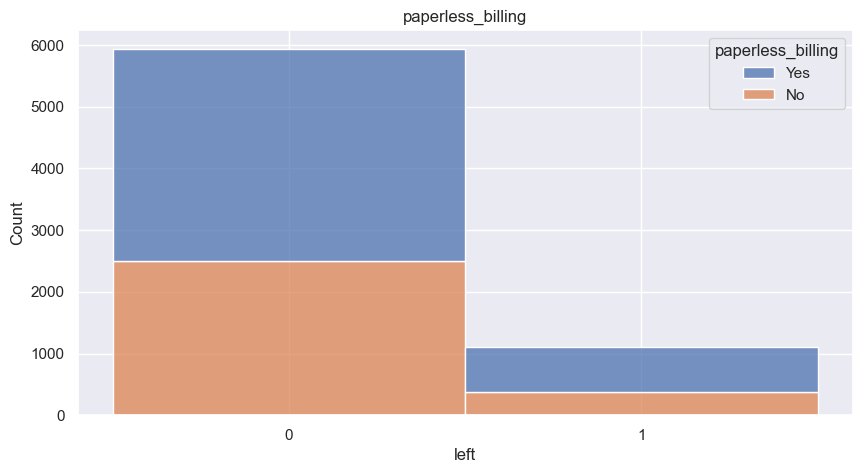

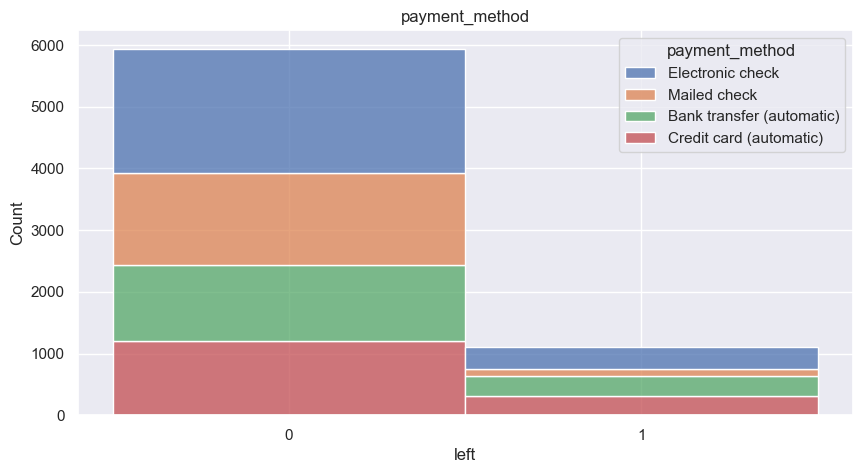

In [37]:
cat_list = []
for column in df.columns:
    if df[column].dtype == 'object':
        cat_list.append(column)

for column in cat_list:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(df, x=df['left'].astype('str'), hue=column, multiple="stack", binwidth=.5).set_title(column)

### Матрица корреляций

In [38]:
correlation_matrix = df.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'left', 'lifetime'])

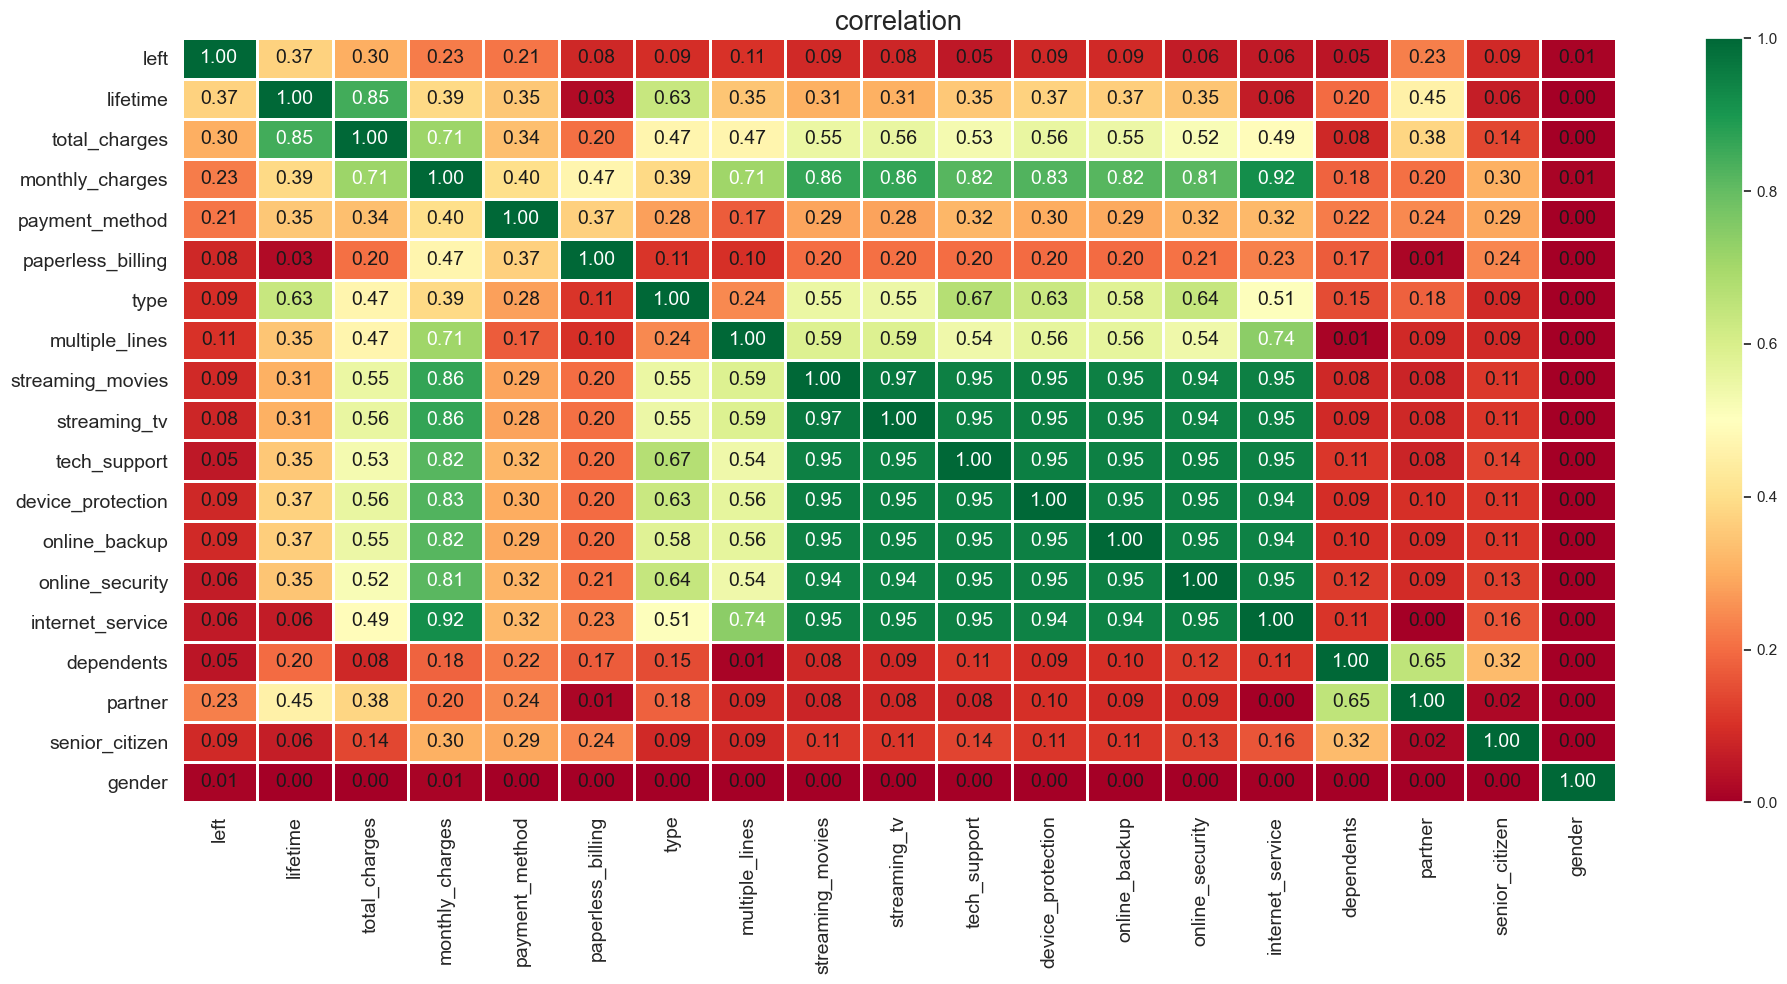

In [39]:
plot_correlation_matrix(correlation_matrix.values,
                        x_labels=correlation_matrix.columns,
                        y_labels=correlation_matrix.index,
                        title='correlation',
                        vmin=0, vmax=1,
                        figsize=(20, 10),
                        fontsize_factor=1.4)

In [40]:
internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

Можно заметить высокую корреляцию между услугами из таблицы `internet`. Похоже эти услуги обычно берут пакетом, и они, как и `multiple_lines` с `internet_service`, имеют высокий уровень корреляции с `monthly_charges`.

`total_charges` напрямую коррелируется со столбцом `lifetime`.

In [41]:
df = df.drop(['online_security', 'online_backup', 
              'device_protection', 'tech_support', 
              'streaming_tv', 'total_charges',
              'multiple_lines', 'streaming_movies',
              'internet_service'], axis=1)

**Вывод:**
- Клиенты предпочитают ежемесячный тип оплаты
- Среди ушедших больше клиентов с партнерами, когда же с оставшимися наоборот
- График ушедших по времени использования близится к нормальному распределению с пиком около 1000 дней
- Большинство клиентов пользуются услугами менее 100 дней
- Имеется дисбаланс в целевом признаке, но не критичный
- Услуги из пакета `internet` похоже берут пакетом

# Обучение модели

In [42]:
cat_list = []
for column in df.columns:
    if df[column].dtype == 'object':
        cat_list.append(column)

numeric_list = df.columns.drop(cat_list)
numeric_list = numeric_list.drop(['senior_citizen', 'left'])
numeric_list

Index(['monthly_charges', 'lifetime'], dtype='object')

In [43]:
cv_params = {
    'scoring':'roc_auc',
    'cv':4
}

## Разделим данные

In [44]:
features = df.drop(['left'], axis=1)
target = df['left']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, random_state=RANDOM_STATE
)

print('Обучающая выборка:', features_train.shape, target_train.shape)
print('Тестовая выборка:', features_test.shape, target_test.shape)

Обучающая выборка: (5282, 9) (5282,)
Тестовая выборка: (1761, 9) (1761,)


## RandomForestClassifier

In [45]:
%%time

RFC_column_transformer = make_column_transformer(
    (OneHotEncoder(drop='first'), cat_list),
    (StandardScaler(), numeric_list),
    remainder='passthrough'
)

Wall time: 0 ns


In [46]:
model_RFC = RandomForestClassifier(
    class_weight='balanced', random_state=RANDOM_STATE
)

In [47]:
pipeline_RFC = make_pipeline(RFC_column_transformer, model_RFC)

params_RFC = { 
    'randomforestclassifier__n_estimators': range(50, 401, 50),
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__max_depth': range(3, 15)
}

In [48]:
GS_RFC = GridSearchCV(
    pipeline_RFC,
    param_grid=params_RFC,
    **cv_params,
    n_jobs=-1
)

GS_RFC.fit(features_train, target_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['gender',
                                                                          'partner',
                                                                          'dependents',
                                                                          'type',
                                                                          'paperless_billing',
                                                                          'payment_method']),
                                                                        ('standardscaler',
                          

In [49]:
GS_RFC.best_params_, GS_RFC.best_score_

({'randomforestclassifier__max_depth': 6,
  'randomforestclassifier__max_features': 'auto',
  'randomforestclassifier__n_estimators': 150},
 0.8162560664934727)

In [50]:
model_metric = pd.DataFrame(columns=['model', 'AUC_score'])
model_metric.loc[0,] = ['RandomForestClassifier', GS_RFC.best_score_]
model_metric

,model,AUC_score
0,RandomForestClassifier,0.816256


## LogisticRegression

In [51]:
%%time

LR_column_transformer = make_column_transformer(
    (OneHotEncoder(drop='first'), cat_list),
    (StandardScaler(), numeric_list),
    remainder='passthrough'
)

model_LR = LogisticRegression(
    class_weight='balanced', random_state=RANDOM_STATE
)

pipeline_LR = make_pipeline(LR_column_transformer, model_LR)

params_LR = { 
    'logisticregression__C': np.arange(.1, 1.01, .01),
    'logisticregression__solver': ['lbfgs', 'liblinear']
}

GS_LR = GridSearchCV(
    pipeline_LR,
    param_grid=params_LR,
    **cv_params,
    n_jobs=-1
)

GS_LR.fit(features_train, target_train)

Wall time: 4.94 s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['gender',
                                                                          'partner',
                                                                          'dependents',
                                                                          'type',
                                                                          'paperless_billing',
                                                                          'payment_method']),
                                                                        ('standardscaler',
                          

In [52]:
GS_LR.best_params_, GS_LR.best_score_

({'logisticregression__C': 0.8499999999999996,
  'logisticregression__solver': 'liblinear'},
 0.7236054180157019)

In [53]:
model_metric.loc[1,] = ['LogisticRegression', GS_LR.best_score_]

## CatBoostClassifier

In [54]:
%%time

model_CBC = CatBoostClassifier(
    auto_class_weights='Balanced',
    random_state=RANDOM_STATE,
    verbose=False,
    cat_features=cat_list
)

params_CBC = { 
    'max_depth': range(4, 11, 2),
    'learning_rate': [.005, .01, .1],
    'n_estimators': range(50, 901, 50)
}

GS_CBC = RandomizedSearchCV(
    model_CBC,
    params_CBC,
    **cv_params,
    n_jobs=-1
)

GS_CBC.fit(features_train, target_train)

Wall time: 2min


RandomizedSearchCV(cv=4,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000019C8C42B340>,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.005, 0.01, 0.1],
                                        'max_depth': range(4, 11, 2),
                                        'n_estimators': range(50, 901, 50)},
                   scoring='roc_auc')

In [55]:
GS_CBC.best_params_, GS_CBC.best_score_

({'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.1},
 0.9125544440837869)

In [56]:
model_metric.loc[2,] = ['CatBoostClassifier', GS_CBC.best_score_]

## Важность признаков лучшей модели

Лучший показатель у модели CatBoostClassifier, посмотрим важность ее признаков.

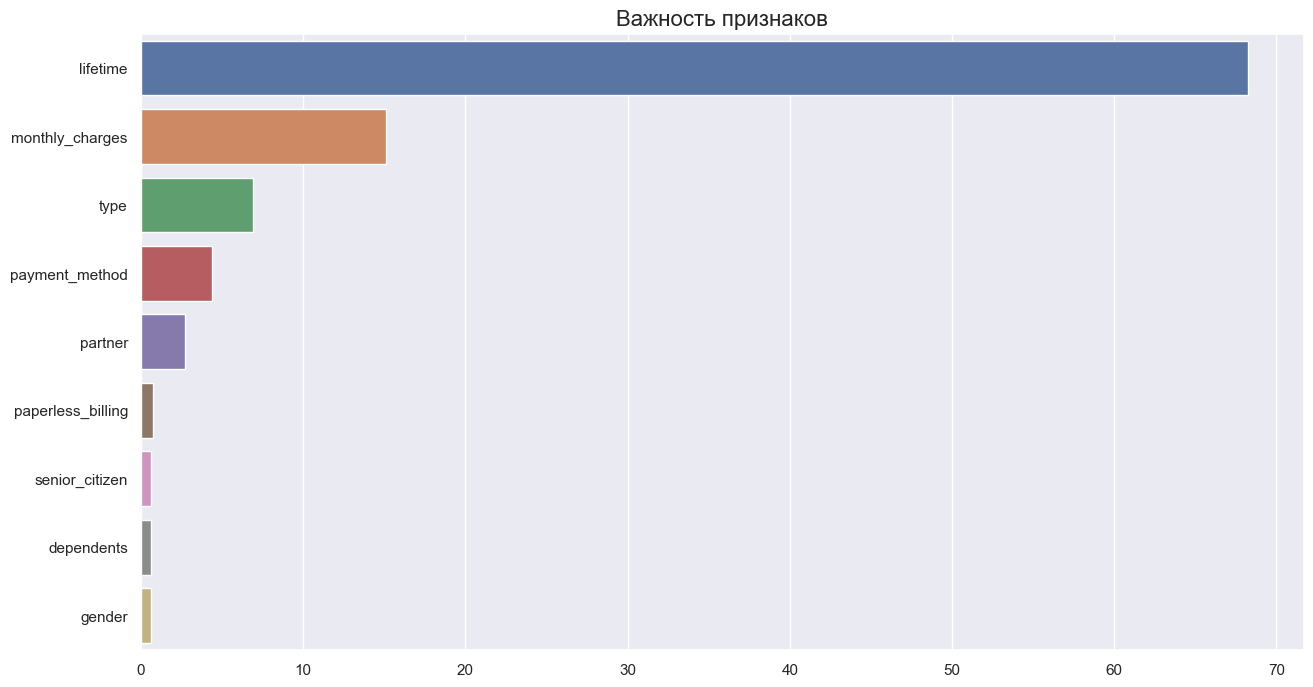

In [57]:
model = GS_CBC.best_estimator_.fit(features_train, target_train)

feature_importance = pd.Series(model.feature_importances_,
                               index=features_train.columns).sort_values(ascending=False)
plt.figure(figsize=(15, 8))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Важность признаков', fontsize=16);

Наибольший вклад вносят признаки:
- `lifetime`
- `monthly_charges`

## Тестирование лучшей модели

In [58]:
model_results = {}

preds = model.predict(features_test)

model_results['AUC_ROC'] = roc_auc_score(target_test, model.predict_proba(features_test)[:, 1])
model_results['precision'] = precision_score(target_test, preds)
model_results['recall'] = recall_score(target_test, preds)
model_results['accuracy'] = accuracy_score(target_test, preds)

In [59]:
model_results

{'AUC_ROC': 0.9223309608540925,
 'precision': 0.6235632183908046,
 'recall': 0.7722419928825622,
 'accuracy': 0.889267461669506}

Получилось достичь необходимого результата в `AUC_ROC` > *0.85*.

## Матрица ошибок

In [60]:
conf_matrix = confusion_matrix(target_test, preds, labels=model.classes_, normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                    display_labels=model.classes_)

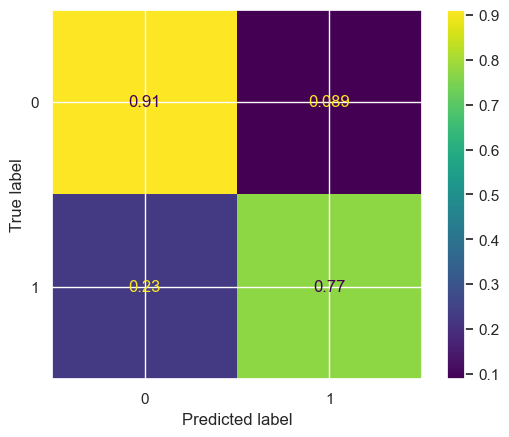

In [61]:
cm_display.plot()
plt.show()

**TP**: Истинно положительные. Модель правильно предсказывает, что клиент уйдет в `77%`.

**TN**: Истинно отрицательные. Модель очень хорошо предсказывает, что клиент останется, в `91%` она права.

**FP**: Ложно положительные. Модель дает неправильный ответ, что клиент уйдет в `9%` случаев, когда он остается.

**FN**: Ложно отрицательные. Модель неправильно предсказывает, что клиент останется в `23%` случаев, когда он уходит.

## Вывод

Было обучено 3 модели. Лучшей оказалась `CatBoostClassifier` с метрикой **AUC_ROC=0.92**.

Самыми важными метриками оказались:
- Время жизни клиента 
- Тип подключения
- Месячная плата

# Отчет

## План работы

Первоначальный план:

1. Подготовка информации
    - Объединить данные, избавиться от аномалий и привести в общему виду
2. EDA
    - Посмотреть на распределение целевого признака
    - Изучить категориальные и количественные признаки
3. Обучение модели
    - Подготовить данные для обучения (закодировать и разбить на выборки)
    - Выбрать модель для обучения
    - Оптимизировать лучшую модель и выполнить требования заказчика относительно модели

## Соответствие проделанной работы запланированной

В целом фактический план работы соответствует запланированному. 

## Трудности

### Отсутствие целевого признака

Изначально в датасете не было целевого признака.

Если изучить столбец с `EndDate`, можно заметить, что у все еще клиентов пропуск в этом столбце. Отсюда и был получен целевой признак.

### Матрица корреляций

По матрице корреляций можно заметить, что имеется достаточное количество столбцов, которые имеют высокий уровень корреляции с другим столбцом.

Было решено избавиться от таких столбцов.

## Предобработка

Так как данные были в нескольких таблицах, мы их объединили и обработали появившиеся пропуски, а также аномалии, которые могли бы неблагополучно повлиять на качество финальной модели.

После мы добавили несколько столбцов с интересующей нас информацией: целевой признак, срок жизни клиента. А также избавились от столбцов, которые нам неинтересны и которые имеют высокий уровень корреляции с другим.

## Список признаков

In [62]:
cat_list, numeric_list

(['gender',
  'partner',
  'dependents',
  'type',
  'paperless_billing',
  'payment_method'],
 Index(['monthly_charges', 'lifetime'], dtype='object'))

Категориальные признаки:
- `gender`: гендер
- `partner`: в браке ли
- `dependents`: есть ли иждивенцы
- `type`: тип оплаты
- `paperless_billing`: безбумажное выставление счетов
- `payment_method`: как оплачивается счет

Для **`RandomForestClassifier`** и **`LogisticRegression`** категориальные признаки были закодированы с помощью *OneHotEncoder*. У **`CatBoostClassifier`** есть внутренний кодировщик категориальных признаков, который и был использован.

Численные признаки:
- `monthly_charges`: ежемесячная плата
- `lifetime`: время жизни клиента

Численные признаки были стандартизированы с помощью *StandardScaler*.

## Обученные модели

Всего было обучено 3 модели:

In [63]:
model_metric

,model,AUC_score
0,RandomForestClassifier,0.816256
1,LogisticRegression,0.723605
2,CatBoostClassifier,0.912554


## Лучшая модель

Лучшей моделью оказалась `CatBoostClassifier`.

С гиперпараметрами:

In [64]:
GS_CBC.best_params_

{'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.1}

И метрикой AUC-ROC:

In [65]:
GS_CBC.best_score_

0.9125544440837869

## Итоговая метрика

В итоге на тестовой выборке модель имеет следующие показатели:

In [66]:
model_results

{'AUC_ROC': 0.9223309608540925,
 'precision': 0.6235632183908046,
 'recall': 0.7722419928825622,
 'accuracy': 0.889267461669506}

## Матрица ошибок

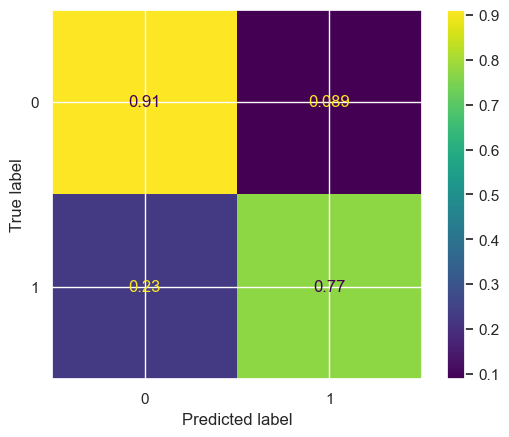

In [67]:
cm_display.plot()
plt.show()

**TP**: Истинно положительные. Модель правильно предсказывает, что клиент уйдет в `77%`.

**TN**: Истинно отрицательные. Модель очень хорошо предсказывает, что клиент останется, в `91%` она права.

**FP**: Ложно положительные. Модель дает неправильный ответ, что клиент уйдет в `9%` случаев, когда он остается.

**FN**: Ложно отрицательные. Модель неправильно предсказывает, что клиент останется в `23%` случаев, когда он уходит.

## Важность признаков

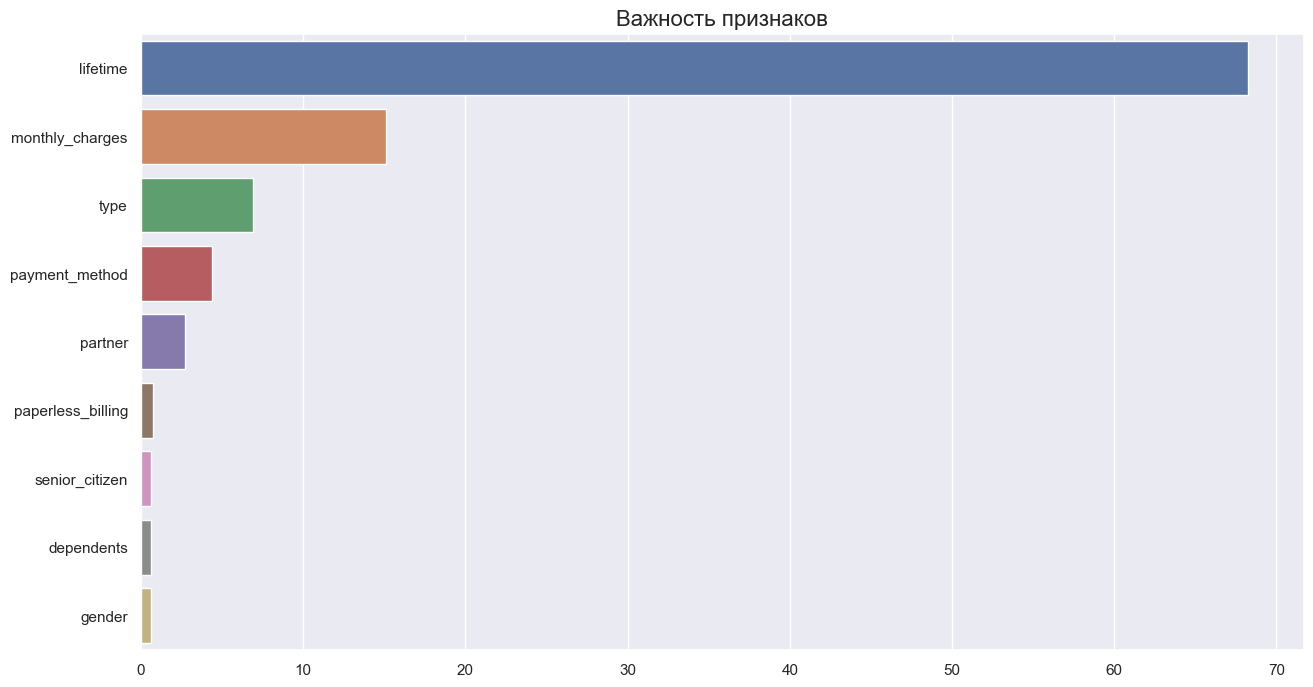

In [69]:
plt.figure(figsize=(15, 8))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Важность признаков', fontsize=16);

Самые важные признаки:
- `lifetime`
- `monthly_charges`

При том можно заметить, что признак `lifetime` сильно вырывается по важности по сравнению со вторым местом.